### KNN on SVHN

#### Import the data from drive

In [0]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
np.seterr(over='ignore')
import os
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/DLCP/Project-1/Data/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

x_train = x_train.reshape(x_train.shape[0], 1024)
x_test = x_test.reshape(x_test.shape[0], 1024)

# # normalize inputs from 0-255 to 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

print('Training set', x_train.shape, y_train.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (42000, 1024) (42000,)
Test set (18000, 1024) (18000,)


In [0]:
print(x_train.shape)
print(y_train.shape)

(42000, 1024)
(42000,)


In [0]:
print(x_test.shape)
print(y_test.shape)

(18000, 1024)
(18000,)


### Visualizing the first 10 images in the dataset and their labels

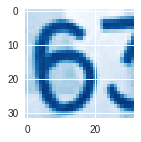

Label:6


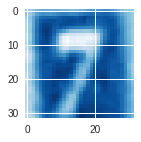

Label:7


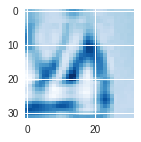

Label:4


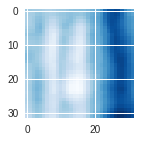

Label:4


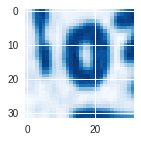

Label:0


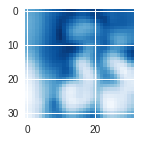

Label:3


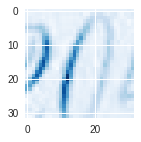

Label:0


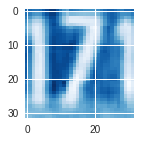

Label:7


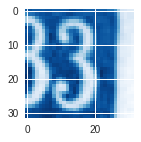

Label:3


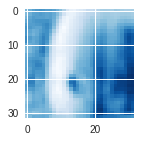

Label:1


In [0]:
# Reshape the array
new_xtrain = x_train.reshape((x_train.shape[0], 32, 32))

# To display first 10 images from Training set along with their labels
for i in range(1,11):
  fig = plt.figure(figsize=(2,2))
  img = new_xtrain[i]
  plt.imshow(img, interpolation='nearest', cmap='Blues_r')
  plt.show()
  print("Label:{}".format(y_train[i]))



### Build KNN and predict the outputs for images from the test data.

In [0]:
import pandas as pd
import numpy as np


class KNN:
    def __init__(self):
        pass

    def train(self, x_train, y_train):
        """
        Memorises the training set
        Parameters :
                 x_train - Training images
                 y_train - Labels of training images
        Return value : None
        """
        self.x_train = x_train
        self.y_train = y_train

    def majority(self, label_list):
        """
        Function: Picks the label from the list of label based on majority
        count.
        Parameters :
            label_list - List of K nearest labels
        Return value : Label with the majority count
        """
        from collections import Counter
        count_list = Counter(label_list)
        value, count = count_list.most_common()[0]
        return value

    def distance_L1(self, x_test, x_train):
        """
        Function : Calculates the distance between the given test data point
        and training data point using L1 or Manhattan method
        Two numpy matrices at each data point is subtracted from one another
        and then taken absolute of it. Then all the values in the resultant
        matrix is added to get the single sum value.
        Parameters :
            x_test - Testing data point
            x_train - Training data point
        Return value : Distance between the data points
        """
        sum = 0
        sum += np.absolute(x_train - x_test)
        return sum.sum()
      
    def distance_L2(self, x_test, x_train):
        """
        Function : Calculates the distance between the given test data point
        and training data point using L2 or Euclidean distance.
        Two numpy matrices at each data point is subtracted from one another
        and then it is squared. Then all the values in the resultant
        matrix is added to get the single sum value.
        Parameters :
            x_test - Testing data point
            x_train - Training data point
        Return value : Distance between the data points
        """
        sum = 0
        for i in range(0, len(x_test)):
          sum = sum + np.square(x_test[i] - x_train[i])
        return np.sqrt(sum)


    def predict(self, x_test, K):
        """
        Function : Predicts the label of the test image by taking the
        majority vote label of the given K nearest training images.
        Parameters :
            x_test - Testing data point
            K - Number of nearest neighbours to be considered for
            label prediction
        Return value : Predicted Label
        """
        min_dist = 2000

        # Create a dictionary of all distances and labels
        dist_dict = {'distance': [], 'label': []}

        # Calculate the distance of all the training point from Testing point
        # and store the minimum distances and its corresponding labels in the
        # dictionary
        for i in range(0, len(x_train) - 1):            
            distance = self.distance_L2(x_test, x_train[i])
            if distance <= min_dist:
                min_dist = distance
                dist_dict['distance'].append(min_dist)
                dist_dict['label'].append(y_train[i])

        # Store the dictionary to Dataframe for the ease of data access and
        # manipulation
        dist_df = pd.DataFrame(dist_dict)
        KNN_dist_list = dist_dict['distance']

        # Sort distances in Ascending order
        KNN_dist_list.sort()

        # Discard the distance values beyond K length
        try:
            KNN_dist_list = KNN_dist_list[:K]
        except Exception:
            KNN_dist_list = KNN_dist_list[:]
            pass        

        # Create a corresponding list of K labels of nearest neighbours
        KNN_label_list = []
        try:
            for i in range(0, K):
                KNN_label_list.append((dist_df[
                    dist_df['distance'] == KNN_dist_list[i]][
                    'label']).to_string(index=False))
        except Exception:
            pass

        # Create a set with unique labels
        label_set = set(KNN_label_list)

        # If number of unique labels is equal to K, which signifies that all
        # the labels of the K nearest neighbours are different,
        # then the predicted label can be given by the label of nearest
        # neighbour
        # else if all the K nearest neighbours have the same label, then the
        # label is given as the predicted label
        # else return the label with majority count
        if len(label_set) == K:
            predicted_label = (
            dist_df[dist_df['distance'] == KNN_dist_list[0]]['label']).to_string(
                index=False)
        elif len(label_set) == 1:
            predicted_label = KNN_label_list[0]
        else:
            predicted_label = self.majority(KNN_label_list)
        return predicted_label
      
      


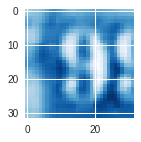

Predicted Label: 9


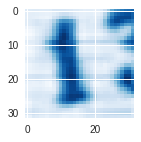

Predicted Label: 1
CPU times: user 3min 3s, sys: 348 ms, total: 3min 4s
Wall time: 3min 3s


In [0]:
%%time

K = 3

# Flattening of 2D matrix of Training image 
x_tr = []
for i in range(32000):
    x_tr.append(new_xtrain[i, :].flatten())

# Instantiate the class object and call the train method
classifier = KNN()
classifier.train(x_tr, y_train)


# Reshaping matrix of Testing image 
new_x_test = x_test.reshape((x_test.shape[0], 32, 32))
           

# Flattening 2D matrix of Testing dataset
x_te = []
for i in range(15000):
    x_te.append(new_x_test[i, :].flatten())

        
# Create a plot of the testing image and predict its label
for i in range(5,7):
    fig = plt.figure(figsize=(2, 2))
    img = new_x_test[i]
    fig.add_subplot(1, 1, 1)
    plt.imshow(img, interpolation='nearest', cmap='Blues_r')
    plt.show()
    print("Predicted Label: {}".format(classifier.predict(x_te[i], K)))

    
      
def accuracy(K,x_te,y_test):
    """
    Function : To determine the accuracy of the predictions provided by KNN
    algorithm.
    If an image is accurately predicted, the score is added by 1 else 0.
    Parameters : None
    Return value : Accuracy percentage
    """
    accuracy_score = 1
    total_accuracy_score = 0
    max_tests = 100
    for i in range(0, max_tests):
        predicted_label = classifier.predict(x_te[i], K)
        if int(predicted_label) == int(y_test[i]):
            total_accuracy_score += accuracy_score
    print("Accuracy score: {}".format(total_accuracy_score))
    accuracy_percentage = (total_accuracy_score * 100) / max_tests
    return accuracy_percentage


def set_K():
  """
  Function : To determine the value of K for which the model performance is 
  best on Test set from the odd numbers in the range 0 to 60
  Parameter : None
  Return : Value of K
  """
  accuracy_list = []
  K_list = []
  for i in range(1,60,2):    
    accuracy_list.append(accuracy(i))
    K_list.append(i)
  dict_obj = {'accuracy' : accuracy_list}  
  df = pd.DataFrame(data=dict_obj,index=K_list)
  K = df['accuracy'].idxmax()
  return K
    
# print("Highest Value predicted when K = {}".format(set_K()))
      
      
# Validation set( subset of training set,not used for training the model) to determine model accuracy    
# x_validate = []
# for i in range(32000,42000):
#     x_validate.append(new_xtrain[i,:].flatten())

    
# y_validate = y_train[32000:42000,]   

# print("Accuracy with validation dataset:{} %".format(accuracy(K, x_validate, y_validate)))
# print("Accuracy percentage with Test dataset :{} %".format(accuracy(K, x_te, y_test)))

In [0]:
_

''